In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [1]:
#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
import random
# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

In [2]:
normalizeddataframe=pd.read_csv('forcetorquebuttonresults_10_13_2021.csv')#.head()
originaldataframe=normalizeddataframe

In [3]:
print(normalizeddataframe.shape)
print(normalizeddataframe.shape[0])


(7200, 30)
7200


We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [7]:
#Un Normalize data



xforce_normalized=-0.014937

xforce_original=(((xforce_normalized+1)/2)*(xforcemax-xforcemin)+xforcemin)
print(xforce_original)
xforce_normalized2=((xforce_original-xforcemin)/(xforcemax-xforcemin)*2)-1

print(xforce_normalized2)

-0.14936999999999934
-0.014936999999999978


In [5]:
#a=4764/6
#print(a)

print(int(normalizeddataframe.shape[0]/6))

794.0
1200


In [4]:
normalizeddataframe=pd.read_csv('forcetorquebuttonresults_10_13_2021.csv')#.head()
originaldataframe=normalizeddataframe
#unnormalizerange=range(0,5,575)
#print(unnormalizerange)

xforcemin=-10
xforcemax=10
yforcemin=-10
yforcemax=10

zforcemin=-15
zforcemax=10
rolltorquemin=-2
rolltorquemax=2
pitchtorquemin=-2
pitchtorquemax=2
yawtorquemin=-.1
yawtorquemax=.1

for i in range(0,int(normalizeddataframe.shape[0]),6):
  
    originaldataframe.iloc[i]=(((normalizeddataframe.iloc[i]+1)/2)*(xforcemax-xforcemin)+xforcemin)
    originaldataframe.iloc[i+1]=(((normalizeddataframe.iloc[i+1]+1)/2)*(yforcemax-yforcemin)+yforcemin)
    originaldataframe.iloc[i+2]=(((normalizeddataframe.iloc[i+2]+1)/2)*(zforcemax-zforcemin)+zforcemin)
    originaldataframe.iloc[i+3]=(((normalizeddataframe.iloc[i+3]+1)/2)*(rolltorquemax-rolltorquemin)+rolltorquemin)
    originaldataframe.iloc[i+4]=(((normalizeddataframe.iloc[i+4]+1)/2)*(pitchtorquemax-pitchtorquemin)+pitchtorquemin)
    

originaldataframe.to_csv('forcetorquebuttonresults_unnormalized_10_13_2021.csv', index=False)  
print("data output to file")


data output to file


In [4]:
#Find new min and max values for each set of data

originaldataframe=pd.read_csv('forcetorquebuttonresults_unnormalized_10_13_2021.csv')#.head()
print(originaldataframe.shape)
xforcemin=999
xforcemax=-999
yforcemin=999
yforcemax=-999
zforcemin=999
zforcemax=-999
rolltorquemin=999
rolltorquemax=-999
pitchtorquemin=999
pitchtorquemax=-999


for i in range(0,int(originaldataframe.shape[0]),6):
    xtempmin=originaldataframe.iloc[i].min(axis=0)
    xtempmax=originaldataframe.iloc[i].max(axis=0)
    ytempmin=originaldataframe.iloc[i+1].min(axis=0)
    ytempmax=originaldataframe.iloc[i+1].max(axis=0)
    ztempmin=originaldataframe.iloc[i+2].min(axis=0)
    ztempmax=originaldataframe.iloc[i+2].max(axis=0)
    rolltempmin=originaldataframe.iloc[i+3].min(axis=0)
    rolltempmax=originaldataframe.iloc[i+3].max(axis=0)
    pitchtempmin=originaldataframe.iloc[i+4].min(axis=0)
    pitchtempmax=originaldataframe.iloc[i+4].max(axis=0)
    
    if xtempmin<xforcemin:
        xforcemin=xtempmin
    if ytempmin<yforcemin:
        yforcemin=ytempmin
    if ztempmin<zforcemin:
        zforcemin=ztempmin
        #print("row",i+2,"new min =",zforcemin)
    #if ztempmin<-50:
        #print("row",i+2,"low z =",zforcemin)
        
    if rolltempmin<rolltorquemin:
        rolltorquemin=rolltempmin
   
        
    if xtempmax>xforcemax:
        xforcemax=xtempmax
    if ytempmax>yforcemax:
        yforcemax=ytempmax
    if ztempmax>zforcemax:
        zforcemax=ztempmax
        #print("new max=",zforcemax)
    if rolltempmax>rolltorquemax:
        rolltorquemax=rolltempmax

    if pitchtempmin<pitchtorquemin:
        pitchtorquemin=pitchtempmin    
        
    if pitchtempmax>pitchtorquemax:
        pitchtorquemax=pitchtempmax   
   
 
    
print("xforcemin=",xforcemin,"xforcemax=",xforcemax)
print("yforcemin=",yforcemin,"yforcemax=",yforcemax)
print("zforcemin=",zforcemin,"zforcemax=",zforcemax)
print("rolltorquemin=",rolltorquemin,"rolltorquemax=",rolltorquemax)
print("pitchtorquemin=",pitchtorquemin,"pitchtorquemax=",pitchtorquemax)






(7200, 30)
xforcemin= -23.11346244812012 xforcemax= 20.14745140075684
yforcemin= -28.277559280395508 yforcemax= 48.10685729980469
zforcemin= -136.04910278320312 zforcemax= 10.252020835876465
rolltorquemin= -8.972264289855957 rolltorquemax= 5.021342277526856
pitchtorquemin= -6.052636623382568 pitchtorquemax= 5.018896102905273


In [10]:
originaldataframe=pd.read_csv('forcetorquebuttonresults_unnormalized_10_13_2021.csv')#.head()
#Create quantile transformers

xforcearray=np.array([])
#print(xforcearray)

temparray=pd.DataFrame(originaldataframe.iloc[0]).to_numpy()
temparray=temparray.T.flatten()
#print(temparray)
#print(temparray)

#print(temparray[0])
#xforcearray=temparray

print(temparray)
print("xforcearray",xforcearray)
print(xforcearray.shape)

xforcearray=np.append(xforcearray,temparray)
print(xforcearray)
print(xforcearray.shape)

[-0.38371107 -0.46302348  0.04506418 -0.5125801   0.904589   -0.28851596
  0.96290171  1.7063899  -1.83390522 -0.06415987  3.80460715  3.075104
  5.97340536  0.02843975  1.98027706  2.44510412 -1.75635695 -0.77543527
 -0.67004275  3.00724626  3.20980525  2.72190237  7.22309446 -0.55252874
 -0.35685888  0.25577372  0.90019143 -2.79025817 -6.09597921 -4.58737516]
xforcearray []
(0,)
[-0.38371107 -0.46302348  0.04506418 -0.5125801   0.904589   -0.28851596
  0.96290171  1.7063899  -1.83390522 -0.06415987  3.80460715  3.075104
  5.97340536  0.02843975  1.98027706  2.44510412 -1.75635695 -0.77543527
 -0.67004275  3.00724626  3.20980525  2.72190237  7.22309446 -0.55252874
 -0.35685888  0.25577372  0.90019143 -2.79025817 -6.09597921 -4.58737516]
(30,)


In [5]:
originaldataframe=pd.read_csv('forcetorquebuttonresults_10_13_2021.csv')#.head()

xforcearray=np.array([])
yforcearray=np.array([])
zforcearray=np.array([])
rolltorquearray=np.array([])
pitchtorquearray=np.array([])

#print(normalizeddataframe.shape)
#print(int(normalizeddataframe.shape[0]/6))

for i in range(0,int(originaldataframe.shape[0]),6):
    
    x_temparray=pd.DataFrame(originaldataframe.iloc[i]).to_numpy()
    y_temparray=pd.DataFrame(originaldataframe.iloc[i+1]).to_numpy()
    z_temparray=pd.DataFrame(originaldataframe.iloc[i+2]).to_numpy()
    roll_temparray=pd.DataFrame(originaldataframe.iloc[i+3]).to_numpy()
    pitch_temparray=pd.DataFrame(originaldataframe.iloc[i+4]).to_numpy()
    
    xforcearray=np.append(xforcearray,x_temparray.T.flatten())
    yforcearray=np.append(yforcearray,y_temparray.T.flatten())
    zforcearray=np.append(zforcearray,z_temparray.T.flatten())
    rolltorquearray=np.append(rolltorquearray,roll_temparray.T.flatten())
    pitchtorquearray=np.append(pitchtorquearray,pitch_temparray.T.flatten())

print(xforcearray.shape)
print(yforcearray.shape)
print(zforcearray.shape)
print(rolltorquearray.shape)
print(pitchtorquearray.shape)
print(xforcearray[0:10])

(42960,)
(42960,)
(42960,)
(42960,)
(42960,)
[0.05489587 0.04392737 0.04925965 0.04530953 0.061904   0.03618936
 0.03697768 0.03616976 0.03457398 0.04562229]


## Fit transformers

In [7]:
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#results

xforcearray=np.sort(xforcearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
xforcearray_transformer =MinMaxScaler()
xforcearray=xforcearray.reshape(-1, 1)
xforcearray_transformer.fit(xforcearray)
x_transformed=xforcearray_transformer.transform(xforcearray)

yforcearray=np.sort(yforcearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
yforcearray_transformer =MinMaxScaler()
yforcearray=yforcearray.reshape(-1, 1)
yforcearray_transformer.fit(yforcearray)
y_transformed=yforcearray_transformer.transform(yforcearray)

zforcearray=np.sort(zforcearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
zforcearray_transformer =MinMaxScaler()
zforcearray=zforcearray.reshape(-1, 1)
zforcearray_transformer.fit(zforcearray)
z_transformed=zforcearray_transformer.transform(zforcearray)

rolltorquearray=np.sort(rolltorquearray)
#xforcearray_transformer = QuantileTransformer(n_quantiles=4, random_state=0)
rolltorquearray_transformer =MinMaxScaler()
rolltorquearray=rolltorquearray.reshape(-1, 1)
rolltorquearray_transformer.fit(rolltorquearray)
roll_transformed=rolltorquearray_transformer.transform(rolltorquearray)

pitchtorquearray=np.sort(pitchtorquearray)
#pitchtorquearray_transformer= QuantileTransformer(n_quantiles=4, random_state=0)
pitchtorquearray_transformer =MinMaxScaler()
pitchtorquearray=pitchtorquearray.reshape(-1, 1)
pitchtorquearray_transformer.fit(pitchtorquearray)
pitch_transformed=pitchtorquearray_transformer.transform(pitchtorquearray)

print("fit complete")

fit complete


In [7]:
xforcearray=np.sort(xforcearray)

yforcearray=np.sort(yforcearray)

zforcearray=np.sort(zforcearray)
rolltorquearray=np.sort(rolltorquearray)

pitchtorquearray=np.sort(pitchtorquearray)


'\nax6.plot(x_transformed, label="Force:X")\nax6.plot(y_transformed, label="Force:Y")\nax6.plot(z_transformed, label="Force:Z")\nax6.plot(roll_transformed, label="Torque:Roll")\nax6.plot(pitch_transformed, label="Torque:Pitch")\nhandles, labels = ax6.get_legend_handles_labels()\nax6.legend(handles, labels,loc=\'lower right\')\n\nplt.title("All plots, Transformed to betwen 0 and 1")\nplt.show()\n\n'

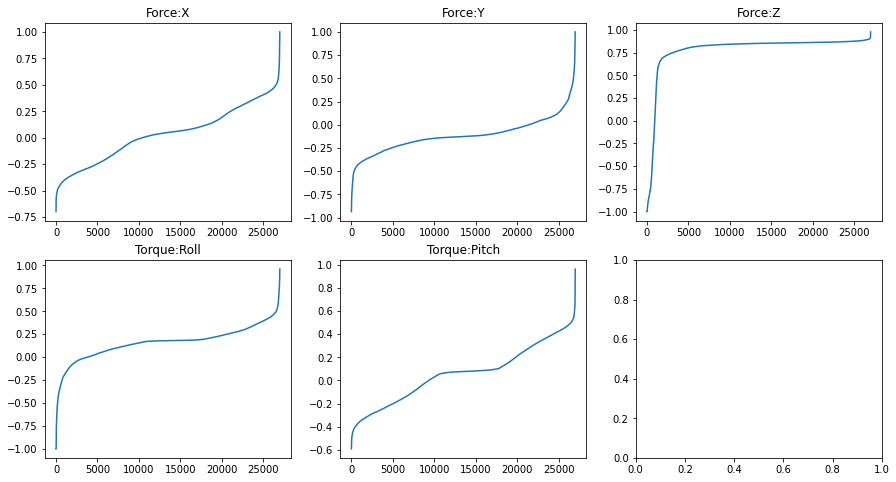

In [8]:
fig = plt.figure(figsize=(15, 8)) #figsize=(25, 80)
ax1 = plt.subplot(2, 3, 1)
ax1.plot(xforcearray)
plt.title("Force:X")
ax2 = plt.subplot(2, 3, 2)
ax2.plot(yforcearray)
plt.title("Force:Y")
ax3 = plt.subplot(2, 3, 3)
ax3.plot(zforcearray)
plt.title("Force:Z")
ax4 = plt.subplot(2, 3, 4)
ax4.plot(rolltorquearray)
plt.title("Torque:Roll")
ax5 = plt.subplot(2, 3, 5)
ax5.plot(pitchtorquearray)
plt.title("Torque:Pitch")
ax6 = plt.subplot(2, 3, 6)    

"""
ax6.plot(x_transformed, label="Force:X")
ax6.plot(y_transformed, label="Force:Y")
ax6.plot(z_transformed, label="Force:Z")
ax6.plot(roll_transformed, label="Torque:Roll")
ax6.plot(pitch_transformed, label="Torque:Pitch")
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels,loc='lower right')

plt.title("All plots, Transformed to betwen 0 and 1")
plt.show()

"""
#plt.plot(x_transformed, label="Force:X")
#plt.title("Force:X")
#plt.show()

## Generate normalized data according to transformers. 

In [44]:

print(originaldataframe.shape)
print(originaldataframe.shape[0]/6)  #795 total episodes. Galues go from 0 to 794
print(int((originaldataframe.shape[0]/6)+1))

(4764, 30)
794.0
795


In [10]:
originaldataframe=pd.read_csv('forcetorquebuttonresults_unnormalized_10_13_2021.csv')#.head()

transformeddataframe=originaldataframe
headers=[]
for i in range(30):
    label=str(i)
    headers.append("header"+label)

#for i in range(0,575,6):
for i in range(0,int((originaldataframe.shape[0])),6):
   # transformeddataframe.iloc[i]=xforcearray_transformer.transform(originaldataframe.iloc[i])
   
    x_temparray=pd.DataFrame(originaldataframe.iloc[i]).to_numpy()
    #print(x_temparray)
    x_temparray=x_temparray.T
    #print(x_temparray)
    x_temparraytransformed=xforcearray_transformer.transform(x_temparray)
    #print("x_temparraytransformed",x_temparraytransformed[0])
    transformeddataframe.iloc[i]= x_temparraytransformed[0]
    #print(transformeddataframe.iloc[i])
    
    y_temparray=pd.DataFrame(originaldataframe.iloc[i+1]).to_numpy()
    y_temparray=y_temparray.T
    y_temparraytransformed=yforcearray_transformer.transform(y_temparray)
    transformeddataframe.iloc[i+1]= y_temparraytransformed[0]
    
    z_temparray=pd.DataFrame(originaldataframe.iloc[i+2]).to_numpy()
    z_temparray=z_temparray.T
    z_temparraytransformed=zforcearray_transformer.transform(z_temparray)
    transformeddataframe.iloc[i+2]= z_temparraytransformed[0]
    
    roll_temparray=pd.DataFrame(originaldataframe.iloc[i+3]).to_numpy()
    roll_temparray=roll_temparray.T
    roll_temparraytransformed=rolltorquearray_transformer.transform(roll_temparray)
    transformeddataframe.iloc[i+3]= roll_temparraytransformed[0]
    
    pitch_temparray=pd.DataFrame(originaldataframe.iloc[i+4]).to_numpy()
    pitch_temparray=pitch_temparray.T
    pitch_temparraytransformed=pitchtorquearray_transformer.transform(pitch_temparray)
    transformeddataframe.iloc[i+4]= pitch_temparraytransformed[0]
    
#uncomment below to update file
transformeddataframe.to_csv('forcetorquebuttonresults_renormalized_10_13_2021.csv', index=False)  
print("data output to file complete2") 

data output to file complete2


In [2]:
#Find new min and max values for each set of data

originaldataframe=pd.read_csv('forcetorquebuttonresults_renormalized_10_13_2021.csv')#.head()
#originaldataframe=pd.read_csv('choppeddata_10_06_2021_equalsuccessfail.csv')#.head()
print(originaldataframe.shape)
print(originaldataframe.shape[0])
print(originaldataframe.shape[0]/6)
xforcemin=999
xforcemax=-999
yforcemin=999
yforcemax=-999
zforcemin=999
zforcemax=-999
rolltorquemin=999
rolltorquemax=-999
pitchtorquemin=999
pitchtorquemax=-999


for i in range(0,int(originaldataframe.shape[0]),6):
    xtempmin=originaldataframe.iloc[i].min(axis=0)
    xtempmax=originaldataframe.iloc[i].max(axis=0)
    ytempmin=originaldataframe.iloc[i+1].min(axis=0)
    ytempmax=originaldataframe.iloc[i+1].max(axis=0)
    ztempmin=originaldataframe.iloc[i+2].min(axis=0)
    ztempmax=originaldataframe.iloc[i+2].max(axis=0)
    rolltempmin=originaldataframe.iloc[i+3].min(axis=0)
    rolltempmax=originaldataframe.iloc[i+3].max(axis=0)
    pitchtempmin=originaldataframe.iloc[i+4].min(axis=0)
    pitchtempmax=originaldataframe.iloc[i+4].max(axis=0)
    
    if xtempmin<xforcemin:
        xforcemin=xtempmin
    if ytempmin<yforcemin:
        yforcemin=ytempmin
    if ztempmin<zforcemin:
        zforcemin=ztempmin
        #print("row",i+2,"new min =",zforcemin)
    #if ztempmin<-50:
        #print("row",i+2,"low z =",zforcemin)
        
    if rolltempmin<rolltorquemin:
        rolltorquemin=rolltempmin
   
        
    if xtempmax>xforcemax:
        xforcemax=xtempmax
    if ytempmax>yforcemax:
        yforcemax=ytempmax
    if ztempmax>zforcemax:
        zforcemax=ztempmax
        #print("new max=",zforcemax)
    if rolltempmax>rolltorquemax:
        rolltorquemax=rolltempmax

    if pitchtempmin<pitchtorquemin:
        pitchtorquemin=pitchtempmin    
        
    if pitchtempmax>pitchtorquemax:
        pitchtorquemax=pitchtempmax   
   
 
    
print("xforcemin=",xforcemin,"xforcemax=",xforcemax)
print("yforcemin=",yforcemin,"yforcemax=",yforcemax)
print("zforcemin=",zforcemin,"zforcemax=",zforcemax)
print("rolltorquemin=",rolltorquemin,"rolltorquemax=",rolltorquemax)
print("pitchtorquemin=",pitchtorquemin,"pitchtorquemax=",pitchtorquemax)




(7200, 30)
7200
1200.0
xforcemin= 0.0 xforcemax= 1.0
yforcemin= 0.0 yforcemax= 1.0
zforcemin= 0.0 zforcemax= 1.0
rolltorquemin= 0.0 rolltorquemax= 1.0
pitchtorquemin= 0.0 pitchtorquemax= 1.0


## Cutting data to final 10 timesteps of every episode

Empty DataFrame
Columns: [header0, header1, header2, header3, header4, header5, header6, header7, header8, header9]
Index: []


In [2]:
headers=[]
for i in range(30):
    label=str(i)
    headers.append("header"+label)
    
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)
    
normalizeddata=pd.read_csv('forcetorquebuttonresults_10_13_2021.csv')#.head()

choppeddata = pd.DataFrame(columns=choppedheaders)

successcounter=0
failcounter=0
#add blocks of 10 timesteps that end in successes to dataset.
for i in range(0,int((normalizeddata.shape[0])-1),6):
    #print("")
    for h in range(len(headers)):
        successflag=False
        if normalizeddata[headers[h]].iloc[i+5]==1:
            tempdata0=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i]).tolist()
            tempdata1=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+1]).tolist()
            tempdata2=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+2]).tolist()
            tempdata3=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+3]).tolist()
            tempdata4=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+4]).tolist()
            tempdata5=(normalizeddata[headers[(h-(lookback-1)):h+1]].iloc[i+5]).tolist()
            
            #tempdata=tempdata.tolist()
            choppeddata.loc[len(choppeddata)]=tempdata0 #add list of data to new row in dataframe
            choppeddata.loc[len(choppeddata)]=tempdata1 
            choppeddata.loc[len(choppeddata)]=tempdata2 
            choppeddata.loc[len(choppeddata)]=tempdata3 
            choppeddata.loc[len(choppeddata)]=tempdata4 
            choppeddata.loc[len(choppeddata)]=tempdata5 
            successflag=True
            successcounter+=1
            break
            
for j in range(successcounter):  #randomly select new blocks of 10 timesteps equal to the number of successes
    finallabel=2
    while finallabel!=0:
        randomepisodeselector=random.randrange(0,int((normalizeddata.shape[0])-1),6)
        k=randomepisodeselector
        randomtimeblockselector=random.randint(0, 30-lookback) 
        tempdata0=(normalizeddata[headers[randomtimeblockselector:randomtimeblockselector+lookback]].iloc[k]).tolist()
        tempdata1=(normalizeddata[headers[randomtimeblockselector:randomtimeblockselector+lookback]].iloc[k+1]).tolist()
        tempdata2=(normalizeddata[headers[randomtimeblockselector:randomtimeblockselector+lookback]].iloc[k+2]).tolist()
        tempdata3=(normalizeddata[headers[randomtimeblockselector:randomtimeblockselector+lookback]].iloc[k+3]).tolist()
        tempdata4=(normalizeddata[headers[randomtimeblockselector:randomtimeblockselector+lookback]].iloc[k+4]).tolist()
        tempdata5=(normalizeddata[headers[randomtimeblockselector:randomtimeblockselector+lookback]].iloc[k+5]).tolist()
        
    
        if tempdata5[lookback-1]==0:
            choppeddata.loc[len(choppeddata)]=tempdata0 #add list of data to new row in dataframe
            choppeddata.loc[len(choppeddata)]=tempdata1 
            choppeddata.loc[len(choppeddata)]=tempdata2 
            choppeddata.loc[len(choppeddata)]=tempdata3 
            choppeddata.loc[len(choppeddata)]=tempdata4 
            choppeddata.loc[len(choppeddata)]=tempdata5 
            #print("randomepisodeselector",randomepisodeselector)
            #print("randomtimeblockselector",randomtimeblockselector)

            finallabel=0
            failcounter+=1
    
    
    
#choppeddata.to_csv('choppeddata_10_06_2021_randomselector.csv', index=False)  
print(choppeddata.shape)
print(choppeddata.shape[0])
print(choppeddata.shape[0]/6)
print("successcounter",successcounter)
print("failcounter",failcounter)
choppeddata.to_csv('choppeddata_10_13_2021_randomselector_even.csv', index=False)  
print("done")


(14700, 10)
14700
2450.0
successcounter 1225
failcounter 1225
done


In [13]:
870*2*6

10440

done


In [8]:
successblocks=pd.read_csv('choppeddata_10_13_2021_randomselector.csv')
print(successblocks.shape[0]/6)



870.0


## ---------------------------OLD Stuff below

In [12]:
print("choppeddata.shape[1]-1",choppeddata.shape[1]-1)

choppeddata.shape[1]-1 9


In [75]:
  3960/6

660.0

data output to file complete


In [28]:
equaldata=pd.read_csv('choppeddata_10_06_2021_equalsuccessfail.csv')#.head()
print(equaldata.shape)

(2700, 10)


In [12]:
print(equaldata.shape[0]/6)

240.0


In [8]:
choppeddata.shape

(4764, 10)